<a href="https://colab.research.google.com/github/Coder-Radiologist/Public/blob/main/Toraks_AI_HandsOn_Kurs_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🫁 Toraks Radyolojisi ve Yapay Zeka: Hands-On Kurs

## Akciğer Segmentasyonu için Derin Öğrenme (U-Net)

**Eğitmen:** Doç. Dr. Mutlu Gülbay  
**Kurum:** Ankara Bilkent Şehir Hastanesi, Radyoloji Anabilim Dalı  
**Kongre:** Antalya Toraks Radyolojisi Kongresi - Mart 2026

---

### 📚 Kurs İçeriği

| Modül | Konu |
|-------|------|
| 1 | Veri Yolağı ve Preprocessing|
| 2 | U-Net Mimarisi |
| 3 | Model Eğitimi |
| 4 | Değerlendirme ve Görselleştirme |

### 🎯 Öğrenme Hedefleri

Bu kursun sonunda katılımcılar:
- Tıbbi görüntüleme verilerinin AI için nasıl hazırlandığını anlayacak
- U-Net segmentasyon mimarisinin temellerini öğrenecek
- Kendi verilerine uyarlayabilecekleri bir pipeline oluşturabilecek
- Segmentasyon metriklerini (Dice, IoU) yorumlayabilecek

---
# 🔧 MODÜL 0: Ortam Kurulumu
---

⚠️ **ÖNEMLİ:** Bu notebook'u çalıştırmadan önce:
1. **Runtime → Change runtime type → T4 GPU** seçin
2. Tüm hücreleri sırayla çalıştırın

In [1]:
# Google Colab'da çalıştığımızı kontrol edelim
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✅ Google Colab ortamında çalışıyoruz!")
    print("\n🖥️ GPU durumunu kontrol edelim...")
    !nvidia-smi --query-gpu=name,memory.total --format=csv
else:
    print("⚠️ Lokal ortamda çalışıyorsunuz")

✅ Google Colab ortamında çalışıyoruz!

🖥️ GPU durumunu kontrol edelim...
name, memory.total [MiB]
NVIDIA A100-SXM4-40GB, 40960 MiB


In [2]:
# Gerekli kütüphaneleri yükleyelim
print("📦 Kütüphaneler yükleniyor... (1-2 dakika sürebilir)")
!pip install -q segmentation-models-pytorch albumentations gdown

print("\n✅ Kütüphaneler yüklendi!")

📦 Kütüphaneler yükleniyor... (1-2 dakika sürebilir)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00

✅ Kütüphaneler yüklendi!


In [3]:
# Temel kütüphaneleri import edelim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import cv2
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Segmentation Models PyTorch
import segmentation_models_pytorch as smp

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Sklearn
from sklearn.model_selection import train_test_split

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Kullanılan cihaz: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("\n⚠️ GPU bulunamadı! Runtime → Change runtime type → T4 GPU seçin.")


🖥️ Kullanılan cihaz: cuda
   GPU: NVIDIA A100-SXM4-40GB
   VRAM: 39.6 GB


---
# 📦 MODÜL 1: Veri Yolağı (Data Pipeline)
---

## 1.1 Veri Seti Hakkında

**Montgomery County X-ray Set:**
- 138 posterior-anterior akciğer grafisi
- 80 normal, 58 tüberküloz bulgulu
- PNG formatında
- Manuel olarak çizilmiş akciğer mask'ları mevcut

📎 **Kaynak:** U.S. National Library of Medicine

In [4]:
# ============================================================
# 📥 VERİ SETİNİ İNDİR (Kaggle hesabı GEREKMİYOR!)
# ============================================================

import gdown
import zipfile

DATA_DIR = Path("./data")

if not DATA_DIR.exists():
    DATA_DIR.mkdir(parents=True)

    print("📥 Veri seti indiriliyor...")
    print("   (Montgomery County Chest X-ray Dataset)\n")

    # Google Drive'dan indir (public link)
    # Bu link eğitmen tarafından hazırlanmış veri setidir
    url = "https://drive.google.com/uc?id=1DuZGJBzb0lx7-SZrRFZYJXvKOQd_GLmv"
    output = "./data/chest_xray_masks.zip"

    try:
        gdown.download(url, output, quiet=False)

        print("\n📂 Dosya açılıyor...")
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)

        os.remove(output)  # Zip dosyasını sil
        print("\n✅ Veri seti hazır!")

    except Exception as e:
        print(f"\n⚠️ Otomatik indirme başarısız: {e}")
        print("\n🔄 Alternatif yöntem deneniyor...")

        # Alternatif: Doğrudan NLM'den indir
        !wget -q https://openi.nlm.nih.gov/imgs/collections/NLM-MontgomeryCXRSet.zip -O ./data/montgomery.zip

        with zipfile.ZipFile("./data/montgomery.zip", 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)

        print("✅ Alternatif kaynak ile indirildi!")
else:
    print("✅ Veri seti zaten mevcut.")

# Klasör yapısını görelim
print("\n📁 Klasör yapısı:")
!ls -la ./data/

📥 Veri seti indiriliyor...
   (Montgomery County Chest X-ray Dataset)


⚠️ Otomatik indirme başarısız: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1DuZGJBzb0lx7-SZrRFZYJXvKOQd_GLmv

but Gdown can't. Please check connections and permissions.

🔄 Alternatif yöntem deneniyor...
✅ Alternatif kaynak ile indirildi!

📁 Klasör yapısı:
total 602420
drwxr-xr-x 4 root root      4096 Jan 22 09:50 .
drwxr-xr-x 1 root root      4096 Jan 22 09:48 ..
drwxr-xr-x 3 root root      4096 Jan 22 09:50 __MACOSX
drwxr-xr-x 5 root root      4096 Jan 22 09:50 MontgomerySet
-rw-r--r-- 1 root root 616853875 Sep  6  2016 montgomery.zip


In [5]:
# Veri yollarını otomatik bul
print("🔍 Veri dosyaları aranıyor...\n")

# Olası klasör yapılarını kontrol et
possible_paths = [
    (DATA_DIR / "Lung Segmentation" / "CXR_png", DATA_DIR / "Lung Segmentation" / "masks"),
    (DATA_DIR / "CXR_png", DATA_DIR / "masks"),
    (DATA_DIR / "MontgomerySet" / "CXR_png", DATA_DIR / "MontgomerySet" / "ManualMask"),
    (DATA_DIR / "NLM-MontgomeryCXRSet" / "MontgomerySet" / "CXR_png",
     DATA_DIR / "NLM-MontgomeryCXRSet" / "MontgomerySet" / "ManualMask"),
]

IMG_DIR = None
MASK_DIR = None

for img_path, mask_path in possible_paths:
    if img_path.exists():
        IMG_DIR = img_path
        # Mask klasörünü bul
        if mask_path.exists():
            MASK_DIR = mask_path
        else:
            # ManualMask içindeki left/right klasörlerini kontrol et
            parent = mask_path.parent if not mask_path.exists() else mask_path
            if (parent / "ManualMask").exists():
                MASK_DIR = parent / "ManualMask"
        break

if IMG_DIR is None:
    print("❌ Görüntü klasörü bulunamadı!")
    print("\nMevcut klasörler:")
    !find ./data -type d | head -20
else:
    print(f"✅ Görüntü klasörü: {IMG_DIR}")
    print(f"✅ Mask klasörü: {MASK_DIR}")

🔍 Veri dosyaları aranıyor...

✅ Görüntü klasörü: data/MontgomerySet/CXR_png
✅ Mask klasörü: data/MontgomerySet/ManualMask


In [6]:
# Montgomery dataset için mask'ları birleştir (sol + sağ akciğer)
def prepare_montgomery_data(img_dir, mask_dir):
    """
    Montgomery dataset'te sol ve sağ akciğer mask'ları ayrı.
    Bunları birleştirip tek mask oluşturuyoruz.
    """
    data = []

    # Görüntü dosyalarını bul
    image_files = list(img_dir.glob("*.png"))
    print(f"📊 Bulunan görüntü sayısı: {len(image_files)}")

    # Her görüntü için mask bul
    for img_path in image_files:
        img_name = img_path.stem

        # Mask dosyalarını ara (farklı naming convention'lar)
        left_mask = None
        right_mask = None
        combined_mask = None

        # Tek mask dosyası varsa
        single_mask = mask_dir / f"{img_name}_mask.png"
        if single_mask.exists():
            combined_mask = single_mask
        else:
            single_mask = mask_dir / f"{img_name}.png"
            if single_mask.exists():
                combined_mask = single_mask

        # Sol/sağ ayrı mask'lar varsa
        if combined_mask is None:
            left_dir = mask_dir / "leftMask"
            right_dir = mask_dir / "rightMask"

            if left_dir.exists() and right_dir.exists():
                left_mask = left_dir / f"{img_name}_left.png"
                right_mask = right_dir / f"{img_name}_right.png"

                if not left_mask.exists():
                    left_mask = left_dir / f"{img_name}.png"
                if not right_mask.exists():
                    right_mask = right_dir / f"{img_name}.png"

        # Veriyi ekle
        if combined_mask and combined_mask.exists():
            data.append({
                'image_path': str(img_path),
                'mask_path': str(combined_mask),
                'mask_type': 'combined',
                'image_id': img_name
            })
        elif left_mask and right_mask and left_mask.exists() and right_mask.exists():
            data.append({
                'image_path': str(img_path),
                'left_mask': str(left_mask),
                'right_mask': str(right_mask),
                'mask_type': 'separate',
                'image_id': img_name
            })

    return pd.DataFrame(data)

# DataFrame oluştur
df = prepare_montgomery_data(IMG_DIR, MASK_DIR)
print(f"\n✅ Eşleşen görüntü-mask çifti: {len(df)}")
print(f"\nMask tipi dağılımı:")
print(df['mask_type'].value_counts())
df.head()

📊 Bulunan görüntü sayısı: 138

✅ Eşleşen görüntü-mask çifti: 138

Mask tipi dağılımı:
mask_type
separate    138
Name: count, dtype: int64


,image_path,left_mask,right_mask,mask_type,image_id
0,data/MontgomerySet/CXR_png/MCUCXR_0002_0.png,data/MontgomerySet/ManualMask/leftMask/MCUCXR_...,data/MontgomerySet/ManualMask/rightMask/MCUCXR...,separate,MCUCXR_0002_0
1,data/MontgomerySet/CXR_png/MCUCXR_0316_1.png,data/MontgomerySet/ManualMask/leftMask/MCUCXR_...,data/MontgomerySet/ManualMask/rightMask/MCUCXR...,separate,MCUCXR_0316_1
2,data/MontgomerySet/CXR_png/MCUCXR_0390_1.png,data/MontgomerySet/ManualMask/leftMask/MCUCXR_...,data/MontgomerySet/ManualMask/rightMask/MCUCXR...,separate,MCUCXR_0390_1
3,data/MontgomerySet/CXR_png/MCUCXR_0004_0.png,data/MontgomerySet/ManualMask/leftMask/MCUCXR_...,data/MontgomerySet/ManualMask/rightMask/MCUCXR...,separate,MCUCXR_0004_0
4,data/MontgomerySet/CXR_png/MCUCXR_0289_1.png,data/MontgomerySet/ManualMask/leftMask/MCUCXR_...,data/MontgomerySet/ManualMask/rightMask/MCUCXR...,separate,MCUCXR_0289_1


In [7]:
# Mask'ları birleştiren yardımcı fonksiyon
def load_mask(row):
    """Tek veya ayrı mask'ları yükle ve birleştir"""
    if row['mask_type'] == 'combined':
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
    else:
        left = cv2.imread(row['left_mask'], cv2.IMREAD_GRAYSCALE)
        right = cv2.imread(row['right_mask'], cv2.IMREAD_GRAYSCALE)

        # Boyutları eşitle
        if left.shape != right.shape:
            right = cv2.resize(right, (left.shape[1], left.shape[0]))

        # Birleştir (OR işlemi)
        mask = np.maximum(left, right)

    return mask

# Test edelim
test_mask = load_mask(df.iloc[0])
print(f"✅ Mask yükleme testi başarılı!")
print(f"   Boyut: {test_mask.shape}")
print(f"   Değer aralığı: [{test_mask.min()}, {test_mask.max()}]")

✅ Mask yükleme testi başarılı!
   Boyut: (4020, 4892)
   Değer aralığı: [0, 255]


## 1.2 Veri Keşfi (Exploratory Data Analysis)

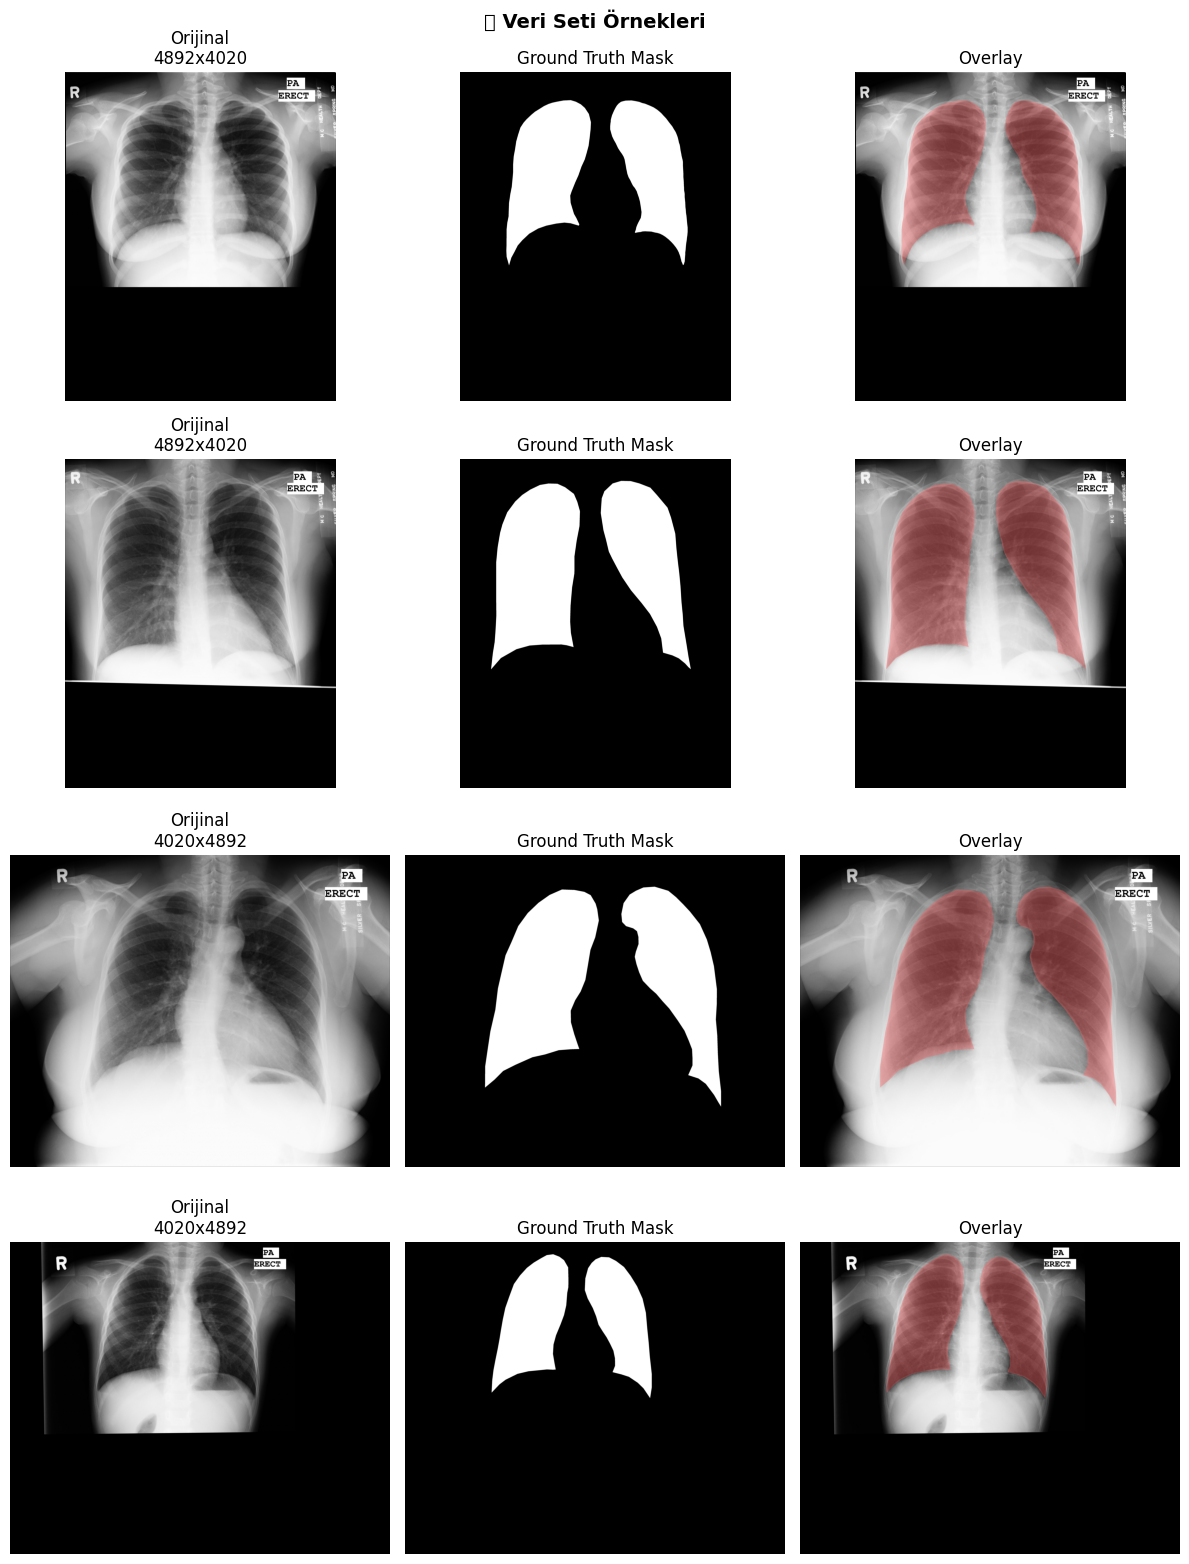

In [8]:
# Örnek görüntüleri görselleştirelim
def visualize_samples(df, num_samples=4):
    """Rastgele örnekleri görüntü ve mask ile birlikte gösterir"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    indices = np.random.choice(len(df), min(num_samples, len(df)), replace=False)

    for i, idx in enumerate(indices):
        row = df.iloc[idx]

        # Görüntü ve mask'ı oku
        img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        mask = load_mask(row)

        # Orijinal görüntü
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Orijinal\n{img.shape[0]}x{img.shape[1]}")
        axes[i, 0].axis('off')

        # Mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"Ground Truth Mask")
        axes[i, 1].axis('off')

        # Overlay
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        mask_binary = (mask > 127).astype(np.uint8) * 255

        # Kırmızı overlay
        overlay = img_rgb.copy()
        overlay[mask_binary > 0] = [255, 100, 100]
        blended = cv2.addWeighted(img_rgb, 0.6, overlay, 0.4, 0)

        axes[i, 2].imshow(blended)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis('off')

    plt.suptitle("📊 Veri Seti Örnekleri", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_samples(df)

## 1.3 Veri Preprocessing

### Neden Preprocessing Gerekli?

1. **Boyut Standardizasyonu:** Farklı boyutlardaki görüntüler aynı boyuta getirilmeli
2. **Normalizasyon:** Piksel değerleri [0,1] veya [-1,1] aralığına normalize edilmeli
3. **Veri Artırma (Augmentation):** Sınırlı veriyle overfitting'i önlemek için

In [9]:
# Sabit parametreler
IMG_SIZE = 256  # Colab GPU için optimal
BATCH_SIZE = 8
NUM_WORKERS = 2

print(f"⚙️ Konfigürasyon:")
print(f"   📐 Hedef görüntü boyutu: {IMG_SIZE}x{IMG_SIZE}")
print(f"   📦 Batch boyutu: {BATCH_SIZE}")

⚙️ Konfigürasyon:
   📐 Hedef görüntü boyutu: 256x256
   📦 Batch boyutu: 8


In [10]:
# Albumentations ile augmentation pipeline
def get_training_augmentation():
    """Eğitim için veri artırma pipeline'ı"""
    return A.Compose([
        # Boyut standardizasyonu
        A.Resize(IMG_SIZE, IMG_SIZE),

        # Geometrik dönüşümler
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.15,
            rotate_limit=15,
            border_mode=cv2.BORDER_CONSTANT,
            p=0.5
        ),

        # Yoğunluk dönüşümleri
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.RandomGamma(gamma_limit=(80, 120)),
        ], p=0.3),

        # Gürültü
        A.GaussNoise(var_limit=(5, 25), p=0.2),

        # Normalizasyon (ImageNet stats - transfer learning için)
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),

        # Tensor'a dönüştür
        ToTensorV2()
    ])

def get_validation_augmentation():
    """Validasyon için sadece resize ve normalizasyon"""
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

print("✅ Augmentation pipeline'ları tanımlandı.")

✅ Augmentation pipeline'ları tanımlandı.


In [11]:
# PyTorch Dataset sınıfı
class LungSegmentationDataset(Dataset):
    """
    Akciğer segmentasyonu için özel Dataset sınıfı
    """

    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Görüntüyü oku (RGB olarak)
        image = cv2.imread(row['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Mask'ı yükle
        mask = load_mask(row)
        mask = (mask > 127).astype(np.float32)  # Binary: 0 veya 1

        # Augmentation uygula
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Mask'ı tensor'a çevir ve kanal boyutu ekle
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0).float()  # (1, H, W)

        return image, mask

print("✅ Dataset sınıfı tanımlandı.")

✅ Dataset sınıfı tanımlandı.


In [12]:
# Train/Validation/Test split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"📊 Veri Seti Bölünmesi:")
print(f"   🟢 Eğitim: {len(train_df)} görüntü ({len(train_df)/len(df)*100:.1f}%)")
print(f"   🟡 Validasyon: {len(val_df)} görüntü ({len(val_df)/len(df)*100:.1f}%)")
print(f"   🔴 Test: {len(test_df)} görüntü ({len(test_df)/len(df)*100:.1f}%)")

📊 Veri Seti Bölünmesi:
   🟢 Eğitim: 96 görüntü (69.6%)
   🟡 Validasyon: 21 görüntü (15.2%)
   🔴 Test: 21 görüntü (15.2%)


In [13]:
# DataLoader'ları oluştur
train_dataset = LungSegmentationDataset(train_df, transform=get_training_augmentation())
val_dataset = LungSegmentationDataset(val_df, transform=get_validation_augmentation())
test_dataset = LungSegmentationDataset(test_df, transform=get_validation_augmentation())

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"✅ DataLoader'lar oluşturuldu.")
print(f"   Eğitim batch sayısı: {len(train_loader)}")
print(f"   Validasyon batch sayısı: {len(val_loader)}")

✅ DataLoader'lar oluşturuldu.
   Eğitim batch sayısı: 12
   Validasyon batch sayısı: 3


In [14]:
# Bir batch'i kontrol edelim
sample_batch = next(iter(train_loader))
images, masks = sample_batch

print(f"📦 Batch Kontrol:")
print(f"   Görüntü shape: {images.shape} (batch, channels, height, width)")
print(f"   Mask shape: {masks.shape}")
print(f"   Görüntü dtype: {images.dtype}")
print(f"   Mask benzersiz değerler: {torch.unique(masks).numpy()}")
print(f"\n✅ Veri pipeline'ı hazır!")

📦 Batch Kontrol:
   Görüntü shape: torch.Size([8, 3, 256, 256]) (batch, channels, height, width)
   Mask shape: torch.Size([8, 1, 256, 256])
   Görüntü dtype: torch.float32
   Mask benzersiz değerler: [0. 1.]

✅ Veri pipeline'ı hazır!


---
# 🏗️ MODÜL 2: U-Net Mimarisi
---

## U-Net Nedir?

U-Net, 2015 yılında biyomedikal görüntü segmentasyonu için geliştirilmiştir.

### Temel Özellikler:
1. **Encoder:** Görüntüden özellik çıkarımı (downsampling)
2. **Decoder:** Segmentasyon haritası üretimi (upsampling)
3. **Skip Connections:** Encoder'dan decoder'a direkt bağlantılar

```
    Encoder          Decoder
    ───────          ───────
    [Input]          [Output]
       │                 ▲
       ▼    ─────────>   │
    [Conv]    Skip    [Conv]
       │    Connection   ▲
       ▼    ─────────>   │
    [Conv]            [Conv]
       │                 ▲
       ▼    ─────────>   │
    [Bottleneck]─────────┘
```

In [15]:
# Segmentation Models PyTorch ile pretrained U-Net
# Transfer learning için ImageNet ağırlıkları kullanılır

model = smp.Unet(
    encoder_name="resnet34",        # Encoder: ResNet34
    encoder_weights="imagenet",      # ImageNet pretrained ağırlıklar
    in_channels=3,                   # RGB giriş
    classes=1,                       # Binary segmentasyon
    activation=None                  # Loss fonksiyonu sigmoid içerecek
)

model = model.to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🏗️ U-Net (ResNet34 Encoder) Model:")
print(f"   Toplam parametre: {total_params:,}")
print(f"   Eğitilebilir parametre: {trainable_params:,}")
print(f"   Model boyutu: ~{total_params * 4 / 1024 / 1024:.1f} MB")

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

🏗️ U-Net (ResNet34 Encoder) Model:
   Toplam parametre: 24,436,369
   Eğitilebilir parametre: 24,436,369
   Model boyutu: ~93.2 MB


In [16]:
# Loss fonksiyonları
class DiceLoss(nn.Module):
    """Dice Loss - Segmentasyon için ideal"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    """BCE ve Dice Loss kombinasyonu"""
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        return self.bce_weight * self.bce(pred, target) + (1 - self.bce_weight) * self.dice(pred, target)

# Metrik fonksiyonları
def dice_coefficient(pred, target, threshold=0.5, smooth=1e-6):
    pred = (torch.sigmoid(pred) > threshold).float()
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    return ((2. * intersection + smooth) / (union + smooth)).item()

def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    pred = (torch.sigmoid(pred) > threshold).float()
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    return ((intersection + smooth) / (union + smooth)).item()

print("✅ Loss ve metrik fonksiyonları tanımlandı.")

✅ Loss ve metrik fonksiyonları tanımlandı.


---
# 🎯 MODÜL 3: Model Eğitimi
---

In [18]:
# Eğitim parametreleri
LEARNING_RATE = 1e-4
NUM_EPOCHS = 25
PATIENCE = 5

criterion = BCEDiceLoss(bce_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print(f"⚙️ Eğitim Konfigürasyonu:")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epoch sayısı: {NUM_EPOCHS}")
print(f"   Early stopping: {PATIENCE} epoch")

⚙️ Eğitim Konfigürasyonu:
   Learning rate: 0.0001
   Epoch sayısı: 25
   Early stopping: 5 epoch


In [19]:
# Eğitim ve validasyon fonksiyonları
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_dice = 0.0, 0.0

    for images, masks in tqdm(loader, desc="Eğitim", leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_dice += dice_coefficient(outputs, masks)

    return running_loss / len(loader), running_dice / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, running_dice, running_iou = 0.0, 0.0, 0.0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validasyon", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            running_loss += criterion(outputs, masks).item()
            running_dice += dice_coefficient(outputs, masks)
            running_iou += iou_score(outputs, masks)

    n = len(loader)
    return running_loss/n, running_dice/n, running_iou/n

print("✅ Eğitim fonksiyonları hazır.")

✅ Eğitim fonksiyonları hazır.


In [20]:
# Ana eğitim döngüsü
history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
best_val_dice = 0.0
patience_counter = 0

print("\n" + "="*60)
print("🚀 EĞİTİM BAŞLIYOR")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch+1}/{NUM_EPOCHS}")

    # Eğitim
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

    # Validasyon
    val_loss, val_dice, val_iou = validate_epoch(model, val_loader, criterion, DEVICE)

    # LR Scheduler
    scheduler.step(val_loss)

    # Geçmişi kaydet
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)

    print(f"   Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f}")
    print(f"   Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    # En iyi modeli kaydet
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"   💾 En iyi model kaydedildi! (Dice: {best_val_dice:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⚠️ Early stopping! {PATIENCE} epoch iyileşme yok.")
            break

print("\n" + "="*60)
print(f"✅ EĞİTİM TAMAMLANDI | En iyi Dice: {best_val_dice:.4f}")
print("="*60)


🚀 EĞİTİM BAŞLIYOR

📅 Epoch 1/25


   Train Loss: 0.5667 | Dice: 0.5541
   Val Loss: 0.5096 | Dice: 0.7192 | IoU: 0.5619
   💾 En iyi model kaydedildi! (Dice: 0.7192)

📅 Epoch 2/25


   Train Loss: 0.4102 | Dice: 0.7908
   Val Loss: 0.3619 | Dice: 0.8415 | IoU: 0.7265
   💾 En iyi model kaydedildi! (Dice: 0.8415)

📅 Epoch 3/25


   Train Loss: 0.3257 | Dice: 0.8809
   Val Loss: 0.2849 | Dice: 0.9126 | IoU: 0.8393
   💾 En iyi model kaydedildi! (Dice: 0.9126)

📅 Epoch 4/25


   Train Loss: 0.2789 | Dice: 0.9121
   Val Loss: 0.2524 | Dice: 0.9235 | IoU: 0.8580
   💾 En iyi model kaydedildi! (Dice: 0.9235)

📅 Epoch 5/25


   Train Loss: 0.2463 | Dice: 0.9305
   Val Loss: 0.2308 | Dice: 0.9406 | IoU: 0.8879
   💾 En iyi model kaydedildi! (Dice: 0.9406)

📅 Epoch 6/25


   Train Loss: 0.2272 | Dice: 0.9329
   Val Loss: 0.2118 | Dice: 0.9496 | IoU: 0.9040
   💾 En iyi model kaydedildi! (Dice: 0.9496)

📅 Epoch 7/25


   Train Loss: 0.2047 | Dice: 0.9456
   Val Loss: 0.2011 | Dice: 0.9538 | IoU: 0.9117
   💾 En iyi model kaydedildi! (Dice: 0.9538)

📅 Epoch 8/25


   Train Loss: 0.1899 | Dice: 0.9490
   Val Loss: 0.1877 | Dice: 0.9491 | IoU: 0.9033

📅 Epoch 9/25


   Train Loss: 0.1754 | Dice: 0.9561
   Val Loss: 0.1763 | Dice: 0.9565 | IoU: 0.9167
   💾 En iyi model kaydedildi! (Dice: 0.9565)

📅 Epoch 10/25


   Train Loss: 0.1624 | Dice: 0.9576
   Val Loss: 0.1645 | Dice: 0.9610 | IoU: 0.9250
   💾 En iyi model kaydedildi! (Dice: 0.9610)

📅 Epoch 11/25


   Train Loss: 0.1512 | Dice: 0.9634
   Val Loss: 0.1528 | Dice: 0.9649 | IoU: 0.9323
   💾 En iyi model kaydedildi! (Dice: 0.9649)

📅 Epoch 12/25


   Train Loss: 0.1425 | Dice: 0.9632
   Val Loss: 0.1458 | Dice: 0.9648 | IoU: 0.9320

📅 Epoch 13/25


   Train Loss: 0.1329 | Dice: 0.9661
   Val Loss: 0.1347 | Dice: 0.9660 | IoU: 0.9342
   💾 En iyi model kaydedildi! (Dice: 0.9660)

📅 Epoch 14/25


   Train Loss: 0.1262 | Dice: 0.9668
   Val Loss: 0.1266 | Dice: 0.9685 | IoU: 0.9390
   💾 En iyi model kaydedildi! (Dice: 0.9685)

📅 Epoch 15/25


   Train Loss: 0.1191 | Dice: 0.9681
   Val Loss: 0.1229 | Dice: 0.9692 | IoU: 0.9402
   💾 En iyi model kaydedildi! (Dice: 0.9692)

📅 Epoch 16/25


   Train Loss: 0.1122 | Dice: 0.9706
   Val Loss: 0.1159 | Dice: 0.9701 | IoU: 0.9419
   💾 En iyi model kaydedildi! (Dice: 0.9701)

📅 Epoch 17/25


   Train Loss: 0.1090 | Dice: 0.9681
   Val Loss: 0.1116 | Dice: 0.9687 | IoU: 0.9393

📅 Epoch 18/25


   Train Loss: 0.1022 | Dice: 0.9718
   Val Loss: 0.1051 | Dice: 0.9689 | IoU: 0.9397

📅 Epoch 19/25


   Train Loss: 0.0949 | Dice: 0.9746
   Val Loss: 0.1009 | Dice: 0.9726 | IoU: 0.9466
   💾 En iyi model kaydedildi! (Dice: 0.9726)

📅 Epoch 20/25


   Train Loss: 0.0916 | Dice: 0.9742
   Val Loss: 0.0984 | Dice: 0.9714 | IoU: 0.9443

📅 Epoch 21/25


   Train Loss: 0.0878 | Dice: 0.9745
   Val Loss: 0.0927 | Dice: 0.9723 | IoU: 0.9462

📅 Epoch 22/25


   Train Loss: 0.0849 | Dice: 0.9747
   Val Loss: 0.0901 | Dice: 0.9726 | IoU: 0.9466
   💾 En iyi model kaydedildi! (Dice: 0.9726)

📅 Epoch 23/25


   Train Loss: 0.0806 | Dice: 0.9763
   Val Loss: 0.0879 | Dice: 0.9709 | IoU: 0.9434

📅 Epoch 24/25


   Train Loss: 0.0777 | Dice: 0.9764
   Val Loss: 0.0831 | Dice: 0.9718 | IoU: 0.9452

📅 Epoch 25/25


   Train Loss: 0.0758 | Dice: 0.9756
   Val Loss: 0.0812 | Dice: 0.9719 | IoU: 0.9454

✅ EĞİTİM TAMAMLANDI | En iyi Dice: 0.9726


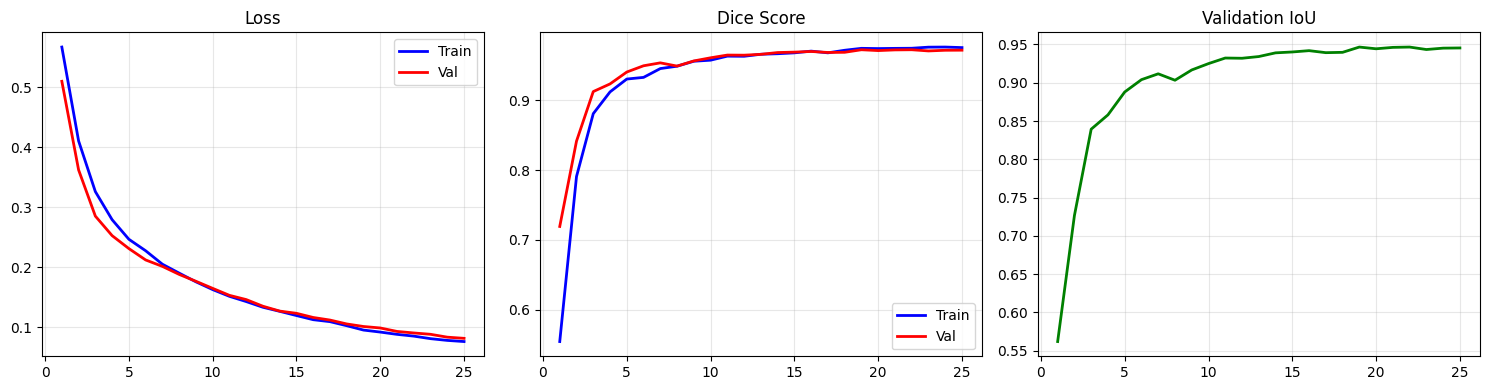

In [21]:
# Eğitim grafiklerini çiz
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
epochs = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, history['train_dice'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs, history['val_dice'], 'r-', label='Val', linewidth=2)
axes[1].set_title('Dice Score'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

axes[2].plot(epochs, history['val_iou'], 'g-', linewidth=2)
axes[2].set_title('Validation IoU'); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

---
# 📊 MODÜL 4: Değerlendirme ve Görselleştirme
---

In [22]:
# En iyi modeli yükle
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
print("✅ En iyi model yüklendi.")

✅ En iyi model yüklendi.


In [23]:
# Test seti değerlendirmesi
all_dice, all_iou = [], []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Test"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)

        for i in range(outputs.shape[0]):
            all_dice.append(dice_coefficient(outputs[i:i+1], masks[i:i+1]))
            all_iou.append(iou_score(outputs[i:i+1], masks[i:i+1]))

print("\n" + "="*50)
print("📊 TEST SONUÇLARI")
print("="*50)
print(f"   Dice: {np.mean(all_dice):.4f} ± {np.std(all_dice):.4f}")
print(f"   IoU:  {np.mean(all_iou):.4f} ± {np.std(all_iou):.4f}")
print("="*50)

Test: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


📊 TEST SONUÇLARI
   Dice: 0.9694 ± 0.0234
   IoU:  0.9416 ± 0.0420


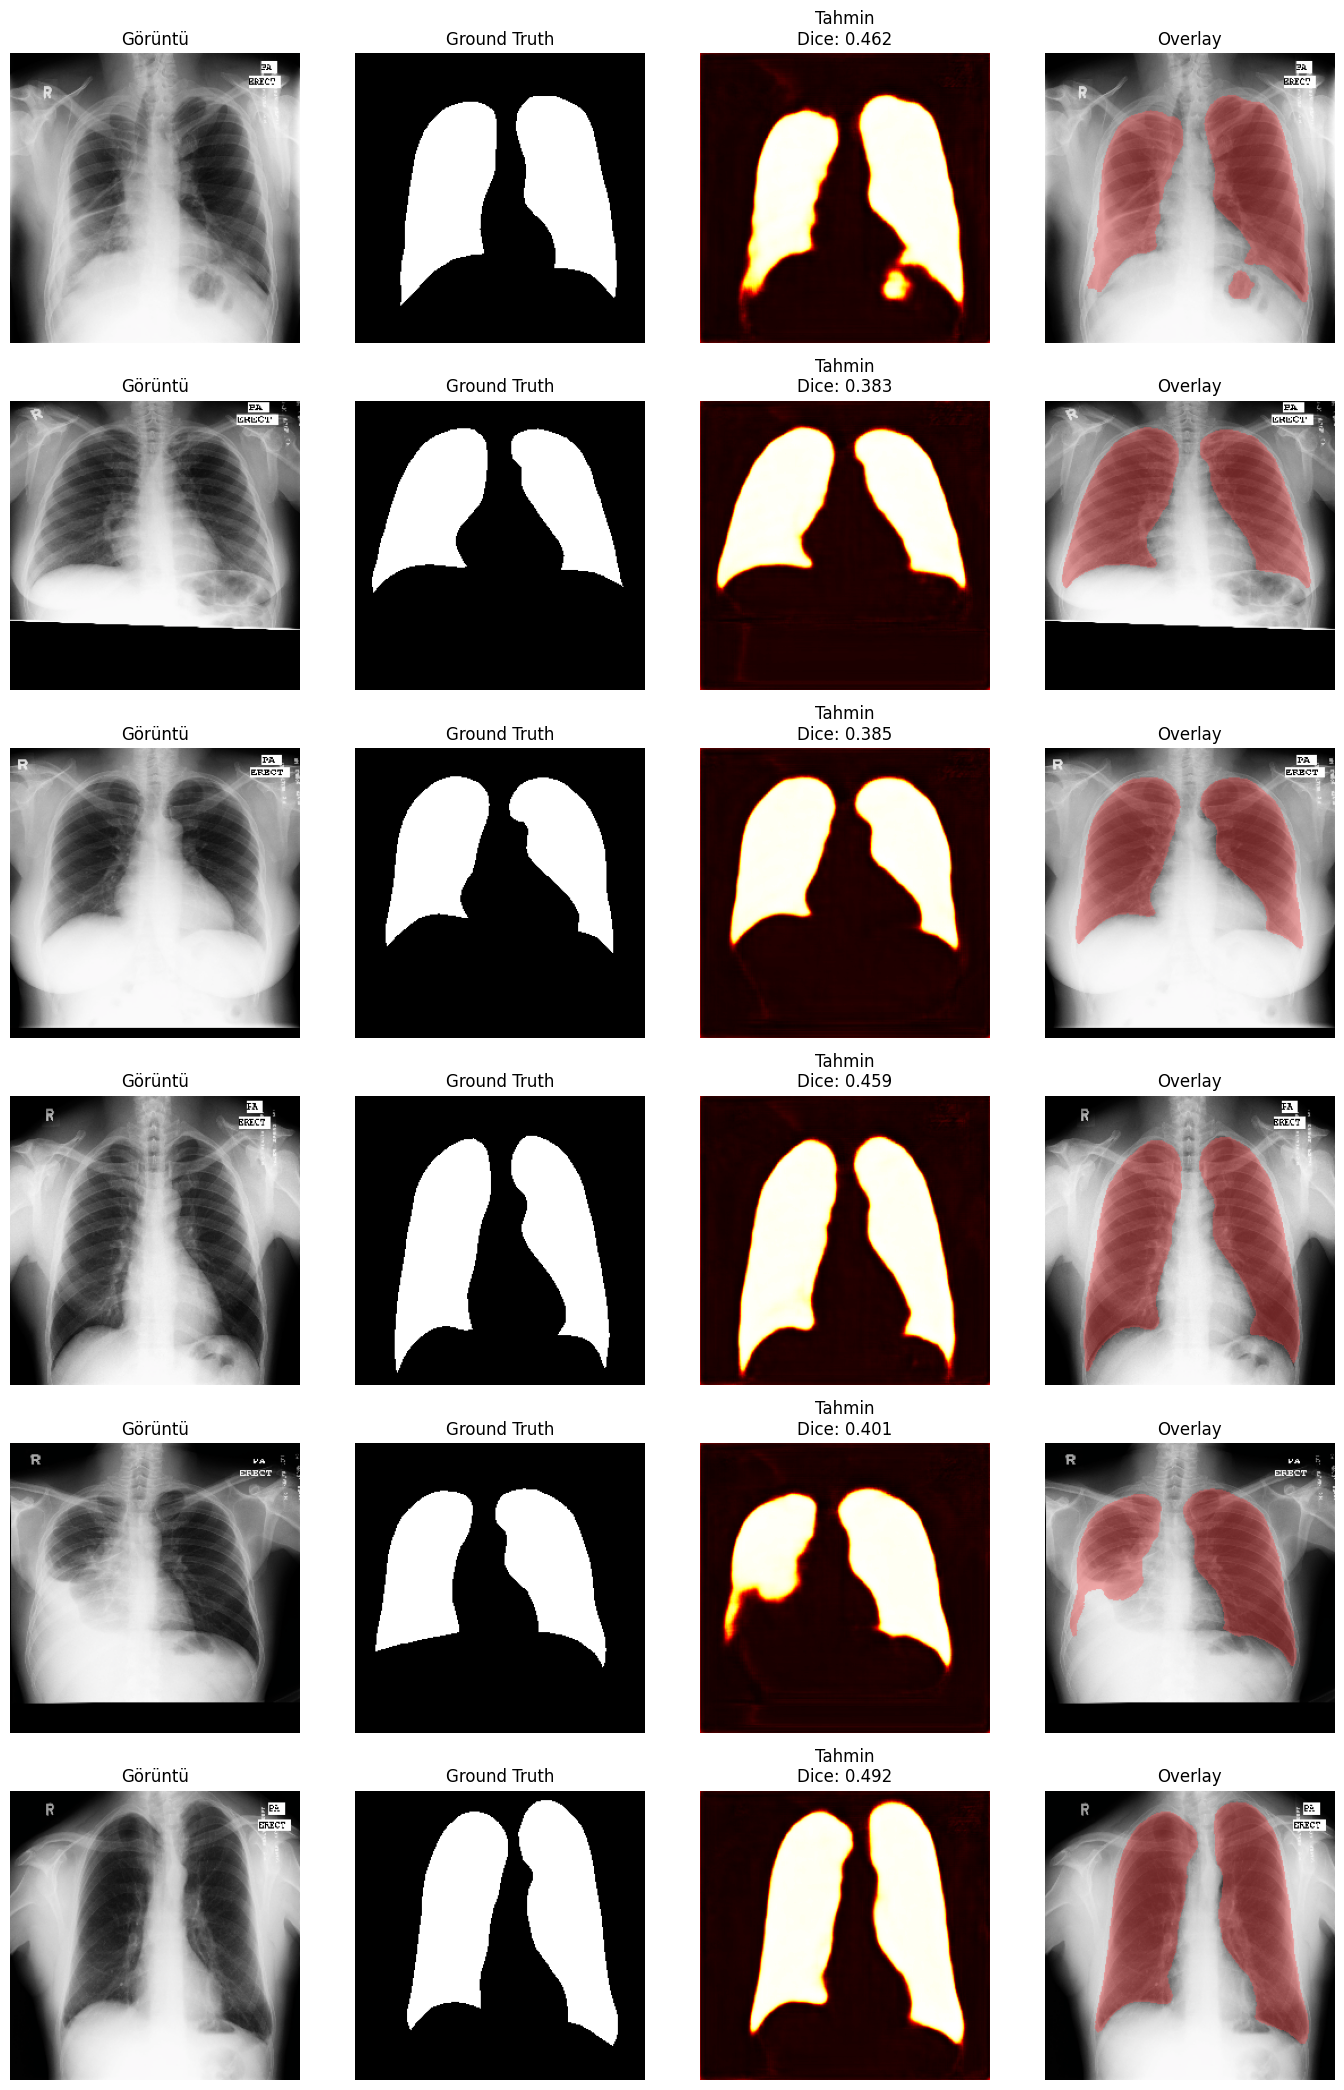

In [24]:
# Tahmin sonuçlarını görselleştir
def show_predictions(model, dataset, device, n=6):
    model.eval()
    fig, axes = plt.subplots(n, 4, figsize=(14, 3.5*n))

    indices = np.random.choice(len(dataset), n, replace=False)

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]

        with torch.no_grad():
            pred = torch.sigmoid(model(image.unsqueeze(0).to(device))).cpu().squeeze().numpy()

        # Denormalize
        img = image.permute(1,2,0).numpy()
        img = np.clip(img * [0.229,0.224,0.225] + [0.485,0.456,0.406], 0, 1)
        mask_np = mask.squeeze().numpy()

        dice = dice_coefficient(torch.tensor(pred).unsqueeze(0).unsqueeze(0),
                               torch.tensor(mask_np).unsqueeze(0).unsqueeze(0))

        axes[i,0].imshow(img); axes[i,0].set_title("Görüntü"); axes[i,0].axis('off')
        axes[i,1].imshow(mask_np, cmap='gray'); axes[i,1].set_title("Ground Truth"); axes[i,1].axis('off')
        axes[i,2].imshow(pred, cmap='hot'); axes[i,2].set_title(f"Tahmin\nDice: {dice:.3f}"); axes[i,2].axis('off')

        # Overlay
        overlay = img.copy()
        overlay[pred > 0.5] = [1, 0.3, 0.3]
        axes[i,3].imshow(img*0.6 + overlay*0.4); axes[i,3].set_title("Overlay"); axes[i,3].axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150)
    plt.show()

show_predictions(model, test_dataset, DEVICE)

---
# 🎉 Kurs Özeti
---

In [ ]:
print("""
╔══════════════════════════════════════════════════════════════╗
║                    KURS TAMAMLANDI! 🎉                       ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  📚 Öğrendiklerimiz:                                         ║
║     • Tıbbi görüntü verisi hazırlama                         ║
║     • Data augmentation teknikleri                           ║
║     • U-Net segmentasyon mimarisi                            ║
║     • Transfer learning (ImageNet → Medical)                 ║
║     • Dice Loss ve değerlendirme metrikleri                  ║
║                                                              ║
║  🔬 Sonraki Adımlar:                                         ║
║     • Farklı encoder'lar (EfficientNet, ResNeXt)             ║
║     • 3D segmentasyon (CT verisi için)                       ║
║     • Multi-class segmentasyon                               ║
║     • Attention mekanizmaları                                ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝

Eğitmen: Doç. Dr. Mutlu Gülbay
Ankara Bilkent Şehir Hastanesi, Radyoloji ABD
""")